In [1]:
import pickle
import numpy as np
from scipy.spatial import distance
from joblib import load
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from matplotlib import pyplot as plt
from gensim.models.doc2vec import Doc2Vec
from gensim.models import Word2Vec, TfidfModel
from gensim.corpora import Dictionary

# Load data

In [2]:
# validation set questions and corresponding FAQs
data_prefix='../../data/12-08-'
with open(data_prefix + 'val-test.pkl', "rb") as fp:
    test_dic = pickle.load(fp) 

In [3]:
# unlabelled data
# load data:
with open("../../code/embedding/models/doc_data/all_docs_sep.pkl", "rb") as fp:
    all_docs_sep = pickle.load(fp)

faq_ques = all_docs_sep['faq_ques']    
faq_ans = all_docs_sep['faq_ans']
ticket_ques = all_docs_sep['ticket_ques']
ticket_ans = all_docs_sep['ticket_ans']

In [4]:
# quick put together of validation set answers
labelled_data = pd.read_csv('../../data/validate.csv')
all_path = '../../data/12-04-ticket_dat.csv'
x_all = pd.read_csv(all_path)
x_val_ind = list(labelled_data.ticket_id)
x_val_ans = np.asarray(x_all.loc[x_all['ticket_id'].isin(x_val_ind)].sort_values("ticket_id")["answer"])

# TFiDF Question to FAQ similarity

In [5]:
TFiDF_ques = load('../../code/embedding/models/TF-IFD-ticket-ques.joblib')
# make matrix
FAQ_matrix_ques = TFiDF_ques.transform(faq_ans)
ticket_matrix_ques = TFiDF_ques.transform(ticket_ques)
# similarities
sim_matrix_ques = cosine_similarity(FAQ_matrix_ques, ticket_matrix_ques)
# Using Closest FAQ similarity as a measure 
strength_FAQ_ticket_ques = np.max(sim_matrix_ques, axis=0)

In [6]:
val_matrix_ques = TFiDF_ques.transform(test_dic["x_val"])
#
test_dic["y_val"][test_dic["y_val"]==199]=-1
val_pos_ques = val_matrix_ques[test_dic["y_val"]!=-1,:]
val_neg_ques = val_matrix_ques[test_dic["y_val"]==-1,:]
val_neg_ques.shape, val_pos_ques.shape
#
sFT_val_pos_ques = np.max(cosine_similarity(FAQ_matrix_ques, val_pos_ques), axis=0)
sFT_val_neg_ques = np.max(cosine_similarity(FAQ_matrix_ques, val_neg_ques), axis=0)

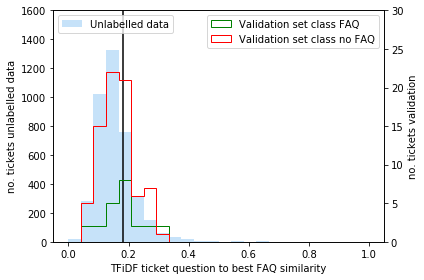

In [22]:
fig, ax1 = plt.subplots()
bins =  np.linspace(0, 1,25)
ax1.hist(strength_FAQ_ticket_ques, bins,alpha=1, label="Unlabelled data", color="#C6E2F9")
ax1.set_xlabel('TFiDF ticket question to best FAQ similarity')
ax1.set_ylabel('no. tickets unlabelled data')
thresh = np.quantile(strength_FAQ_ticket_ques,0.75)
plt.ylim(top=1600) 
plt.axvline(x=thresh,color='k')
ax2 = ax1.twinx()
ax2.hist(sFT_val_pos_ques, bins,alpha=1, label="Validation set class FAQ", color = "green", histtype ="step")
ax2.hist(sFT_val_neg_ques, bins,alpha=1, label="Validation set class no FAQ", color = "red", histtype ="step")
ax2.set_ylabel('no. tickets validation')
plt.ylim(top=30) 

fig.tight_layout()
ax1.legend(loc=2)
ax2.legend()
plt.show()


# TFiDF Answer to FAQ similarity

In [23]:
TFiDF_ans = load('../../code/embedding/models/TF-IFD-ans.joblib')
FAQ_matrix_ans = TFiDF_ans.transform(faq_ans)
ticket_matrix_ans = TFiDF_ans.transform(ticket_ans)
sim_matrix_ans = cosine_similarity(FAQ_matrix_ans, ticket_matrix_ans)
strength_FAQ_ticket_max_ans = np.max(sim_matrix_ans, axis=0)

In [24]:
val_matrix_ans = TFiDF_ans.transform(x_val_ans)
val_pos_ans = val_matrix_ans[test_dic["y_val"]!=-1,:]
val_neg_ans = val_matrix_ans[test_dic["y_val"]==-1,:]
sFT_val_pos_ans = np.max(cosine_similarity(FAQ_matrix_ans, val_pos_ans), axis=0)
sFT_val_neg_ans = np.max(cosine_similarity(FAQ_matrix_ans, val_neg_ans), axis=0)

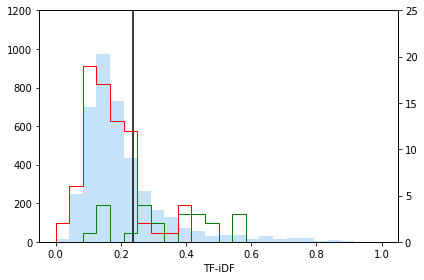

thresh= 0.23799952906832816


In [25]:
fig, ax1 = plt.subplots()
bins =  np.linspace(0, 1,25)
ax1.hist(strength_FAQ_ticket_max_ans, bins,alpha=1, label="Unlabelled data",  color="#C6E2F9")
#ax1.set_xlabel('TF-iDF ticket answer to best FAQ similarity')
ax1.set_xlabel('TF-iDF')
#ax1.set_ylabel('no. tickets unlabelled data')
plt.ylim(top=1200) 
thresh = np.quantile(strength_FAQ_ticket_max_ans,0.75)
plt.axvline(x=thresh,color='k',ymax=1000)
ax2 = ax1.twinx()
ax2.hist(sFT_val_pos_ans, bins,alpha=1, label="Validation set class FAQ", color = "green", histtype ="step")
ax2.hist(sFT_val_neg_ans, bins,alpha=1, label="Validation set class no FAQ", color = "red", histtype ="step")
#ax2.set_ylabel('no. tickets validation')
plt.ylim(top=25) 
fig.tight_layout()
#ax1.legend(loc=2)
#ax2.legend()
plt.show()
print("thresh=",thresh)

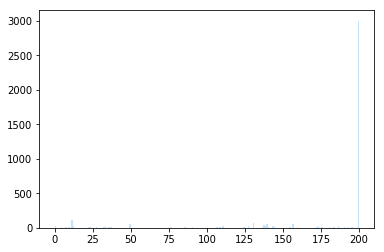

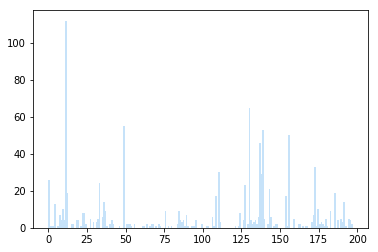

In [49]:
FAQ_per_ticket = np.argmax(sim_matrix_ans, axis=0)
FAQ_per_ticket[strength_FAQ_ticket_max_ans<thresh]=200

plt.hist(FAQ_per_ticket, bins=200,alpha=1, color="#C6E2F9")
plt.show()
plt.hist(FAQ_per_ticket[FAQ_per_ticket<200], bins=199,alpha=1, color="#C6E2F9")

plt.show()

In [45]:
unique, counts = np.unique(FAQ_per_ticket, return_counts=True)
print(unique,counts, len(unique))

[  0   1   2   3   4   6   7   8   9  10  11  12  15  16  18  19  21  22
  23  24  27  29  31  32  33  35  36  37  38  40  41  42  46  49  51  52
  53  54  56  61  62  64  66  67  68  70  72  73  76  78  80  84  85  86
  87  88  89  90  91  93  94  95  96  99 102 103 106 107 108 110 111 121
 123 124 126 127 129 130 131 132 133 134 135 136 137 138 139 140 142 143
 144 146 147 148 154 155 156 159 162 163 165 167 168 171 172 173 174 175
 176 177 178 179 180 181 183 186 188 190 191 192 193 195 196 197 200] [  26    1    1    1   13    1    7    4   10    4  112   19    2    2
    4    4    1    8    8    2    5    3    3    5   24    6   14    9
    1    2    4    2    1   55    2    2    2    1    2    1    1    2
    1    2    2    1    2    1    9    1    1    2    9    4    3    4
    1    7    1    1    1    1    4    2    1    1    6    1   17   30
    3    1    1    8    4   23    2   65    4    2    3    4    2    6
   46   29   53    5    2   21    6    1    2    2   17    1   50 

# doc2vec similarity

In [228]:
model_path = '../../code/embedding/models/doc2vec_ans.model'
model = Doc2Vec.load(model_path)

n_faq = len(faq_ans)
n_ticket = len(ticket_ans)
faq_em = np.array([model.docvecs[i] for i in range(n_faq)])
ticket_em = np.array([model.docvecs[i] for i in range(n_faq, n_faq + n_ticket)])

val_prepro = preprocess_docs_fn(x_val_ans)
# embed data
doc2vec_val = np.array([model.infer_vector(val_prepro[i]) for i in range(len(val_prepro))])

In [229]:
SFT, valyes, valno = do_stuff(faq_em, ticket_em, doc2vec_val)

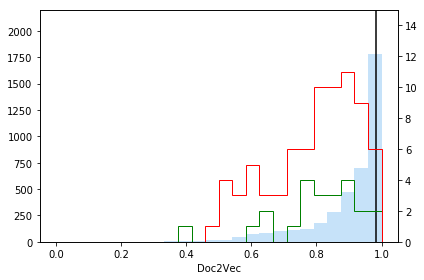

thresh= 0.9818815141916275


In [230]:
legend = 'Doc2Vec'
plot_stuff(SFT, valyes, valno, a = 2200, b = 15, l = legend)

# word2vec similarity

In [231]:
model_path = '../../code/embedding/models/word2vec_all.model'
model = Word2Vec.load(model_path)
# word2vec is trained on 
all_docs = faq_ques + faq_ans + ticket_ques + ticket_ans
all_docs_prepro = preprocess_docs_fn(all_docs)
#
ind_tix_ans_start = 2*len(faq_ans) + len(ticket_ques)
ind_tix_ans_end = 2*len(faq_ans) + 2*len(ticket_ques)

In [232]:
mean_ticket_ans = doc_emb_one_MR(ind_start=ind_tix_ans_start,
                                 ind_end=ind_tix_ans_end,
                                 all_docs_prepro=all_docs_prepro,
                                 model=model)
ind_faq_ans_start = len(faq_ans)
ind_faq_ans_end = 2*len(faq_ans)
mean_faq_ans = doc_emb_one_MR(ind_start=ind_faq_ans_start,
                                 ind_end=ind_faq_ans_end,
                                 all_docs_prepro=all_docs_prepro,
                                 model=model)

#val_prepro = preprocess_docs_fn(x_val_ans) # this was already done above
word2vec_val = doc_emb_new_one_MR(ind_start=0, 
                                  ind_end=len(x_val_ans),
                                  all_docs_prepro=val_prepro,
                                  model=model)

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [91]:
# checking something happened :)
np.sum(word2vec_val>0)/(100*128), len(val_prepro)

(0.48046875, 100)

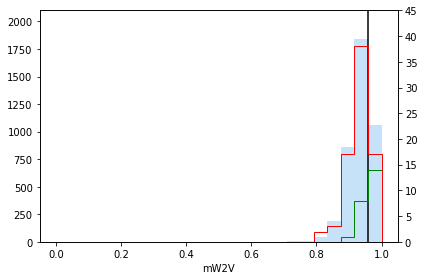

thresh= 0.9594214713109103


In [233]:
SFT, valyes, valno = do_stuff(mean_faq_ans, mean_ticket_ans, word2vec_val)
legend = 'mW2V'
plot_stuff(SFT, valyes, valno, a = 2100, b = 45, l = legend)

# word2vec + TFiDF

In [234]:
# TODO: start back here, understand how to predict for new points xxx
print('Loading Word2vec model')
model_path = '../../code/embedding/models/word2vec_all.model'
model_w2v = Word2Vec.load(model_path)

print('Loading Tfidf model')
model_path = '../../code/embedding/models/tfidf_all.model'
model_tfidf = TfidfModel.load(model_path)

dct = Dictionary(all_docs_prepro)
dct_val = Dictionary(val_prepro)
corpus = [dct.doc2bow(line) for line in all_docs_prepro]
corpus_val = [dct_val.doc2bow(line) for line in val_prepro]

Loading Word2vec model
Loading Tfidf model


In [235]:
ind_tix_ans_start = 2*len(faq_ans) + len(ticket_ques)
ind_tix_ans_end = 2*len(faq_ans) + 2*len(ticket_ques)
ind_faq_ans_start = len(faq_ans)
ind_faq_ans_end = 2*len(faq_ans)

mean_ticket_ans = all_avg(doc_prepro=all_docs_prepro,
                          ind_start=ind_tix_ans_start,
                          ind_end=ind_tix_ans_end,
                          corpus=corpus,
                          dct=dct,
                       model_w2v=model_w2v,
                       model_tfidf=model_tfidf)
mean_faq_ans = all_avg(doc_prepro=all_docs_prepro,
                          ind_start=ind_faq_ans_start,
                          ind_end=ind_faq_ans_end,
                          corpus=corpus,
                          dct=dct,
                       model_w2v=model_w2v,
                       model_tfidf=model_tfidf)

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [178]:
last_m_val = all_avg(doc_prepro=val_prepro,
                     ind_start=0,
                     ind_end=len(val_prepro),
                     corpus=corpus_val,
                     dct=dct_val,
                     model_w2v=model_w2v,
                     model_tfidf=model_tfidf)

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [127]:
np.sum(last_m_val>0)/(100*128), len(val_prepro)

(0.49984375, 100)

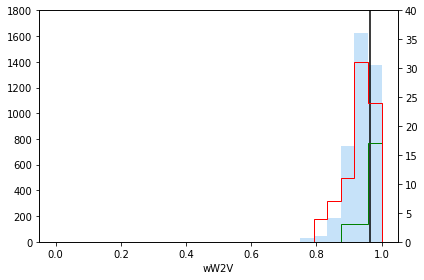

thresh= 0.9655454223000588


In [236]:
SFT, valyes, valno = do_stuff(mean_faq_ans, mean_ticket_ans, last_m_val)
legend = 'wW2V'
plot_stuff(SFT, valyes, valno, a = 1800, b = 40, l = legend)

# AVG W2V on top 5 tfidf weighted words

In [180]:
tix_5w = top5(doc_prepro=all_docs_prepro,
              ind_start=ind_tix_ans_start,
              ind_end=ind_tix_ans_end,
              corpus=corpus,
              dct=dct,
              model_w2v=model_w2v,
              model_tfidf=model_tfidf)
faq_5w = top5(doc_prepro=all_docs_prepro,
                          ind_start=ind_faq_ans_start,
                          ind_end=ind_faq_ans_end,
                          corpus=corpus,
                          dct=dct,
                       model_w2v=model_w2v,
                       model_tfidf=model_tfidf)
val_5w = top5(doc_prepro=val_prepro,
                     ind_start=0,
                     ind_end=len(val_prepro),
                     corpus=corpus_val,
                     dct=dct_val,
                     model_w2v=model_w2v,
                     model_tfidf=model_tfidf)

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


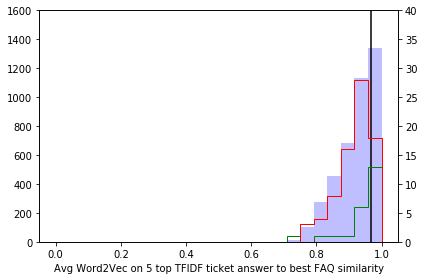

thresh= 0.966302509720917


In [181]:
SFT, valyes, valno = do_stuff(faq_5w, tix_5w, val_5w)
legend = 'Avg Word2Vec on 5 top TFIDF ticket answer to best FAQ similarity'
plot_stuff(SFT, valyes, valno, a = 1600, b = 40, l = legend)

# W2V + TFiDF weighted on TFiDF top 5

In [150]:
tix_5ww = top5_average(doc_prepro=all_docs_prepro,
              ind_start=ind_tix_ans_start,
              ind_end=ind_tix_ans_end,
              corpus=corpus,
              dct=dct,
              model_w2v=model_w2v,
              model_tfidf=model_tfidf)
faq_5ww = top5_average(doc_prepro=all_docs_prepro,
                          ind_start=ind_faq_ans_start,
                          ind_end=ind_faq_ans_end,
                          corpus=corpus,
                          dct=dct,
                       model_w2v=model_w2v,
                       model_tfidf=model_tfidf)
val_5ww = top5_average(doc_prepro=val_prepro,
                     ind_start=0,
                     ind_end=len(val_prepro),
                     corpus=corpus_val,
                     dct=dct_val,
                     model_w2v=model_w2v,
                     model_tfidf=model_tfidf)

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


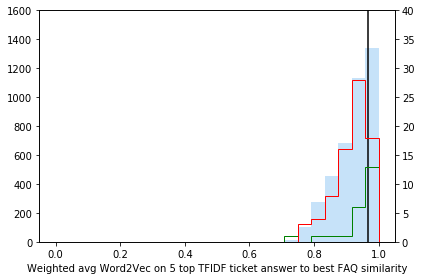

thresh= 0.966302509720917


In [221]:
SFT, valyes, valno = do_stuff(faq_5w, tix_5w, val_5w)
legend = 'Weighted avg Word2Vec on 5 top TFIDF ticket answer to best FAQ similarity'
plot_stuff(SFT, valyes, valno, a = 1600, b = 40, l = legend)

# Utils

In [134]:
def itemgetter(*items):
    if len(items) == 1:
        item = items[0]
        def g(obj):
            return obj[item]
    else:
        def g(obj):
            return tuple(obj[item] for item in items)
    return g

In [220]:
def do_stuff(FAQ_matrix_ans,ticket_matrix_ans, val_matrix_ans):
    sim_matrix_ans = cosine_similarity(FAQ_matrix_ans, ticket_matrix_ans)
    strength_FAQ_ticket_max_ans = np.max(sim_matrix_ans, axis=0)
    val_pos_ans = val_matrix_ans[test_dic["y_val"]!=-1,:]
    val_neg_ans = val_matrix_ans[test_dic["y_val"]==-1,:]
    sFT_val_pos_ans = np.max(cosine_similarity(FAQ_matrix_ans, val_pos_ans), axis=0)
    sFT_val_neg_ans = np.max(cosine_similarity(FAQ_matrix_ans, val_neg_ans), axis=0)
    return strength_FAQ_ticket_max_ans, sFT_val_pos_ans, sFT_val_neg_ans

def plot_stuff(strength_FAQ_ticket_max_ans,sFT_val_pos_ans,sFT_val_neg_ans, a=1200, b=25, l= "GIMME A NAME"):
    fig, ax1 = plt.subplots()
    bins =  np.linspace(0, 1,25)
    ax1.hist(strength_FAQ_ticket_max_ans, bins,alpha=1, label="Unlabelled data", color="#C6E2F9")
    ax1.set_xlabel(l)
    #ax1.set_ylabel('no. tickets unlabelled data')
    thresh = np.quantile(strength_FAQ_ticket_max_ans,0.75)
    plt.axvline(x=thresh,color='k',ymax=a-100)
    plt.ylim(top=a) 
    ax2 = ax1.twinx()
    ax2.hist(sFT_val_pos_ans, bins,alpha=1, label="Validation set class FAQ", color = "green", histtype ="step")
    ax2.hist(sFT_val_neg_ans, bins,alpha=1, label="Validation set class no FAQ", color = "red", histtype ="step")
    #ax2.set_ylabel('no. tickets validation')
    plt.ylim(top=b) 
    fig.tight_layout()
    #ax1.legend(loc=2)
    #ax2.legend()
    plt.show()
    print("thresh=",thresh)

In [27]:
from gensim.parsing.preprocessing import preprocess_string
import re
import string

from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import stem_text
from gensim.parsing.preprocessing import strip_numeric


def remove_ip(s):
    # Replace all ip adresses with '<ip>' tag
    ip_regexp = r"\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b"
    return re.sub(ip_regexp, '<ip>', s)


def remove_email(s):
    # Replace all email adresses with '<email>' tag
    email_regexp = r"([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})"
    return re.sub(email_regexp, '<email>', s)


def remove_mailto(s):
    # Replace all "<mailto:<email>>" with <email>. Email adresses should be replaced by remove_email first.
    return s.replace("<mailto:<email>>", "<email>")


def remove_url(s):
    # Replace all url's with '<url>' tag
    url_regexp = r"((http|ftp|https):\/\/)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"
    s = re.sub(url_regexp, '<url>', s)
    # Sometimes url's are inside <> so we need to replace <<url>> with <url>
    return s.replace("<<url>>", "<url>")


def remove_punc(s, exceptions):
    # Remove all punctuation from string with exceptions in list exceptions
    remove = string.punctuation
    for exception in exceptions:
        remove = remove.replace(exception, "")
    # Create the pattern
    pattern = r"[{}]".format(remove)

    return re.sub(pattern, "", s)


def remove_custom_stopwords(s, stopwords):
    for stopword in stopwords:
        s = s.replace(stopword, "")
    return s


def lower_case(s):
    return s.lower()


def preprocess_sentence_fn(s):
    # Preprocess a single sentence to a list of tokens
    punc_exceptions = ['<', '>']
    custom_stopwords = ['dear', 'sincerely', 'thanks', 'yours', 'regards']

    filters = [lower_case,
               remove_ip,
               remove_email,
               remove_mailto,
               #remove_url,
               lambda x: remove_punc(x, punc_exceptions),
               remove_stopwords,
               lambda x: remove_custom_stopwords(x, custom_stopwords),
               strip_multiple_whitespaces,
               stem_text,
               strip_numeric]
    out = preprocess_string(s, filters=filters)

    return out


def preprocess_docs_fn(docs):
    # Apply preprocess_sentence_fn to a list of sentances (docs) to get a list of lists
    return [preprocess_sentence_fn(s) for s in docs]


In [59]:
# compute sentence embedding for word2vec
def doc_emb_one(name, id_dict, all_docs_prepro, model):
    mean_ans = np.empty((len(id_dict[name]), 128), dtype=float)
    for j in id_dict[name]:
        sentence = all_docs_prepro[j]
        words = np.empty((len(sentence), 128), dtype=float)
        for i in range(len(sentence)):
            words[i] = model[sentence[i]]
        mean_ans[j - id_dict[name][0]] = np.apply_along_axis(np.mean, 0, words)
    return mean_ans

# compute sentence embedding for word2vec
def doc_emb_one_MR(ind_start, ind_end, all_docs_prepro, model):
    length = ind_end - ind_start
    mean_ans = np.empty((length, 128), dtype=float)
    for j in range(ind_start, ind_end):
        sentence = all_docs_prepro[j]
        words = np.empty((len(sentence), 128), dtype=float)
        for i in range(len(sentence)):
            words[i] = model[sentence[i]]
        mean_ans[j - ind_start] = np.apply_along_axis(np.mean, 0, words)
    return mean_ans

# doc2vec equivalent 
# doc2vec_val = np.array([model.infer_vector(val_prepro[i]) for i in range(len(val_prepro))])
def doc_emb_new_one_MR(ind_start, ind_end, all_docs_prepro, model):
    length = ind_end - ind_start
    mean_ans = np.empty((length, 128), dtype=float)
    # extract vocabulary
    word_vectors = model.wv
    for j in range(ind_start, ind_end):
        sentence = all_docs_prepro[j]
        # let's go a little old school
        words = np.empty(128, dtype=float)
        #words = np.empty((len(sentence), 128), dtype=float)
        counter = 0
        for i in range(len(sentence)):
            if sentence[i] in word_vectors.vocab:
                words += model[sentence[i]]
                counter +=1
        mean_ans[j - ind_start] = words/counter
    return mean_ans


# compute sentence embedding for tfidf_w2v
def all_average(dat, corpus, dct, model_w2v, model_tfidf, id_dict, all_docs_prepro):
    if dat == 'faq_ans':
        ind = id_dict['faq_ans'][0]
        leng = len(id_dict['faq_ans'])
        dat = all_docs_prepro[ind:leng]
    elif dat == 'ticket_ans':
        ind = id_dict['ticket_ans'][0]
        leng = len(id_dict['ticket_ans'])
        dat = all_docs_prepro[ind:leng]
    else:
        ind = id_dict['ticket_ques'][0]
        leng = len(id_dict['ticket_ques'])
        dat = all_docs_prepro[ind:leng]
    mean_ans = np.empty((leng, 128), dtype=float)
    for i in range(leng):
        vector = np.asarray(model_tfidf[corpus[ind]], dtype=float)
        words = np.empty((len(vector), 128), dtype=float)
        for j in range(len(vector)):
            words[j] = model_w2v[dct[int(vector[j,0])]]
        mean_ans[i] = np.average(words, 0, weights=vector[:,1])
        ind += 1
    return mean_ans

In [119]:
def all_avg(doc_prepro=all_docs_prepro,
            ind_start=ind_tix_ans_start,
            ind_end=ind_tix_ans_end,
            corpus=corpus,
            dct=dct,
            model_w2v=model_w2v,
            model_tfidf=model_tfidf):
    # extract vocabulary
    word_vectors = model_w2v.wv
    dat = doc_prepro[ind_start:ind_end]
    length = ind_end - ind_start
    mean_ans = np.empty((length, 128), dtype=float)
    for i in range(length):
        vector = np.asarray(model_tfidf[corpus[ind_start]], dtype=float)
        words = np.empty((len(vector), 128), dtype=float)
        for j in range(len(vector)):
            if dct[int(vector[j,0])] in word_vectors.vocab:
                words[j] = model_w2v[dct[int(vector[j,0])]]
            else:
                words[j] = 0
        mean_ans[i] = np.average(words, 0, weights=vector[:,1])
        ind_start += 1
    return mean_ans

In [136]:
def top5(doc_prepro=all_docs_prepro,
         ind_start=ind_tix_ans_start, 
         ind_end=ind_tix_ans_end, 
         corpus=corpus, 
         dct=dct, 
         model_w2v=model_w2v, 
         model_tfidf=model_tfidf):
    word_vectors = model_w2v.wv
    dat = doc_prepro[ind_start:ind_end]
    length = ind_end - ind_start
    mean_ans = np.empty((length, 128), dtype=float)
    for i in range(length):
        vector = model_tfidf[corpus[ind_start]]
        vector_s = sorted(vector, key=itemgetter(1), reverse=True)
        top5 = vector_s[:5]
        top5 = np.asarray(top5, dtype=int)[:,0]
        words = np.empty((len(top5), 128), dtype=float)
        for j in range(len(top5)):
            if dct[int(top5[j])] in word_vectors.vocab:
                words[j] = model_w2v[dct[top5[j]]]
            else:
                words[j] = 0
        mean_ans[i] = np.apply_along_axis(np.mean, 0, words)
        ind_start += 1
    return mean_ans

In [146]:
def top5_average(doc_prepro=all_docs_prepro,
                 ind_start=ind_tix_ans_start, 
                 ind_end=ind_tix_ans_end, 
                 corpus=corpus, 
                 dct=dct, 
                 model_w2v=model_w2v, 
                 model_tfidf=model_tfidf):
    word_vectors = model_w2v.wv
    dat = doc_prepro[ind_start:ind_end]
    length = ind_end - ind_start
    mean_ans = np.empty((len(dat), 128), dtype=float)
    for i in range(length):
        vector = model_tfidf[corpus[ind_start]]
        vector_s = sorted(vector, key=itemgetter(1), reverse=True)
        top5 = vector_s[:5]
        top5 = np.asarray(top5, dtype=float)
        words = np.empty((len(top5), 128), dtype=float)
        for j in range(len(top5)):
            if dct[int(top5[j,0])] in word_vectors.vocab:
                words[j] = model_w2v[dct[int(top5[j,0])]]
            else:
                words[j] = 0
        mean_ans[i] = np.average(words, 0, weights=top5[:,1])
        ind_start += 1
    return mean_ans